# VAE Analysis - Faces Dataset (CelebA)

Analysis of a trained Variational Autoencoder on the CelebA face dataset.

**Contents:**
- Face reconstruction (original vs reconstructed)
- Latent space distribution analysis
- Attribute vector arithmetic (adding/removing features)
- Face morphing between images

## GPU Setup

In [1]:
import tensorflow as tf

# ═══════════════════════════════════════════════════════════════════════════════
# GPU MEMORY GROWTH SETUP
# Prevents TensorFlow from allocating all GPU memory at once
# ═══════════════════════════════════════════════════════════════════════════════
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"GPU enabled: {gpus[0].name}")
else:
    print("No GPU found, using CPU")

2026-01-05 01:40:02.288368: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/cataluna84/Workspace-Antigravity/Generative_Deep_Learning/.venv/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


GPU enabled: /physical_device:GPU:0


## Imports

In [2]:
# Standard library imports
import os
import sys

# Path setup for project utilities
sys.path.insert(0, '../..')  # Project root for utils/
sys.path.insert(0, '..')     # v1/ for src/

# Scientific computing
import numpy as np
import pandas as pd
from scipy.stats import norm

# Visualization
import matplotlib.pyplot as plt

# Local imports
from src.models.VAE import VariationalAutoencoder
from src.utils.loaders import load_model, ImageLabelLoader

## Global Configuration

In [3]:
# ═══════════════════════════════════════════════════════════════════════════════
# GLOBAL CONFIGURATION
# All paths and settings are defined here for easy modification
# ═══════════════════════════════════════════════════════════════════════════════

# Run identification
SECTION = 'vae'
RUN_ID = '0001'
DATA_NAME = 'faces'

# Paths
RUN_FOLDER = f'../run/{SECTION}/{RUN_ID}_{DATA_NAME}'
DATA_FOLDER = '../data/img_align_celeba/'
IMAGE_FOLDER = '../data/img_align_celeba/images/'

# Image dimensions (must match training)
INPUT_DIM = (128, 128, 3)

print(f"Run folder: {RUN_FOLDER}")
print(f"Data folder: {DATA_FOLDER}")

Run folder: ../run/vae/0001_faces
Data folder: ../data/img_align_celeba/


## Data Loading

In [4]:
# Load CelebA attributes CSV
# Contains 40 binary attributes (e.g., Smiling, Eyeglasses, Male) for each image
att = pd.read_csv(os.path.join(DATA_FOLDER, 'list_attr_celeba.csv'))

# Initialize image loader for loading and resizing images
imageLoader = ImageLabelLoader(IMAGE_FOLDER, INPUT_DIM[:2])

print(f"Loaded {len(att)} attribute records")
print(f"Number of attributes: {len(att.columns) - 1}")  # -1 for image_id column

Loaded 202599 attribute records
Number of attributes: 40


In [5]:
# Preview attribute data
att.head()

image_id  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  \
0  000001.jpg                -1                1           1               -1   
1  000002.jpg                -1               -1          -1                1   
2  000003.jpg                -1               -1          -1               -1   
3  000004.jpg                -1               -1           1               -1   
4  000005.jpg                -1                1           1               -1   

   Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  ...  Sideburns  Smiling  \
0    -1     -1        -1        -1          -1  ...         -1        1   
1    -1     -1        -1         1          -1  ...         -1        1   
2    -1     -1         1        -1          -1  ...         -1       -1   
3    -1     -1        -1        -1          -1  ...         -1       -1   
4    -1     -1         1        -1          -1  ...         -1       -1   

   Straight_Hair  Wavy_Hair  Wearing_Earrings  Wearing_Hat  Wearing_Lipstick  \
0              1         -1                 1           -1                 1   
1             -1         -1                -1           -1                -1   
2             -1          1                -1           -1                -1   
3              1         -1                 1           -1                 1   
4             -1         -1                -1           -1                 1   

   Wearing_Necklace  Wearing_Necktie  Young  
0                -1               -1      1  
1                -1               -1      1  
2                -1               -1      1  
3                 1               -1      1  
4                -1               -1      1  

[5 rows x 41 columns]

In [6]:
# Dataset size
print(f"Dataset shape: {att.shape}")

Dataset shape: (202599, 41)


## Model Architecture

In [7]:
# Load trained VAE model from saved weights
vae = load_model(VariationalAutoencoder, RUN_FOLDER)

print(f"Loaded VAE with z_dim={vae.z_dim}")
print(f"Encoder input shape: {vae.encoder.input_shape}")
print(f"Decoder output shape: {vae.decoder.output_shape}")

I0000 00:00:1767577212.901158   70726 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6094 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5


Loaded VAE with z_dim=256
Encoder input shape: (None, 128, 128, 3)
Decoder output shape: (None, 128, 128, 3)


## Face Reconstruction

Test the VAE's ability to encode and reconstruct faces.
The top row shows original images, the bottom row shows reconstructions.

In [8]:
# Number of faces to reconstruct
N_TO_SHOW = 10

# Load sample images
data_flow_generic = imageLoader.build(att, N_TO_SHOW)
example_batch = next(data_flow_generic)
example_images = example_batch[0]

print(f"Loaded {len(example_images)} sample images")

Found 202599 non-validated image filenames.
Loaded 10 sample images


2026-01-05 01:40:16.258474: I external/local_xla/xla/service/service.cc:163] XLA service 0x772d3c003e80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-01-05 01:40:16.258574: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 2070, Compute Capability 7.5
2026-01-05 01:40:16.287297: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-01-05 01:40:16.391347: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91701


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


I0000 00:00:1767577218.681453   70802 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


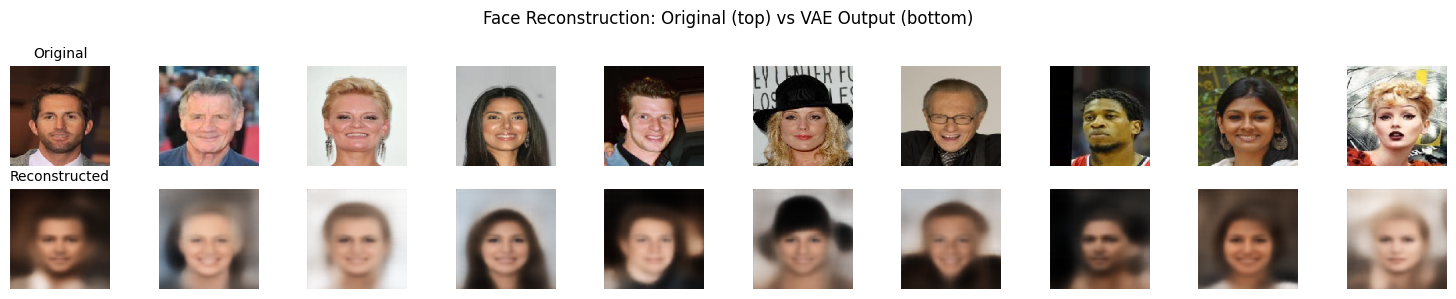

In [9]:
# Encode images to latent space, then decode back
z_points = vae.encoder.predict(example_images)
reconst_images = vae.decoder.predict(z_points)

# Plot original vs reconstructed
fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Top row: Original images
for i in range(N_TO_SHOW):
    ax = fig.add_subplot(2, N_TO_SHOW, i + 1)
    ax.axis('off')
    ax.imshow(example_images[i].squeeze())
    if i == 0:
        ax.set_title('Original', fontsize=10)

# Bottom row: Reconstructed images
for i in range(N_TO_SHOW):
    ax = fig.add_subplot(2, N_TO_SHOW, i + N_TO_SHOW + 1)
    ax.axis('off')
    ax.imshow(reconst_images[i].squeeze())
    if i == 0:
        ax.set_title('Reconstructed', fontsize=10)

plt.suptitle('Face Reconstruction: Original (top) vs VAE Output (bottom)', fontsize=12)
plt.tight_layout()
plt.show()

## Latent Space Distribution

Visualize the distribution of latent dimensions.
A well-trained VAE should have latent dimensions that approximate a standard normal distribution N(0,1).

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step


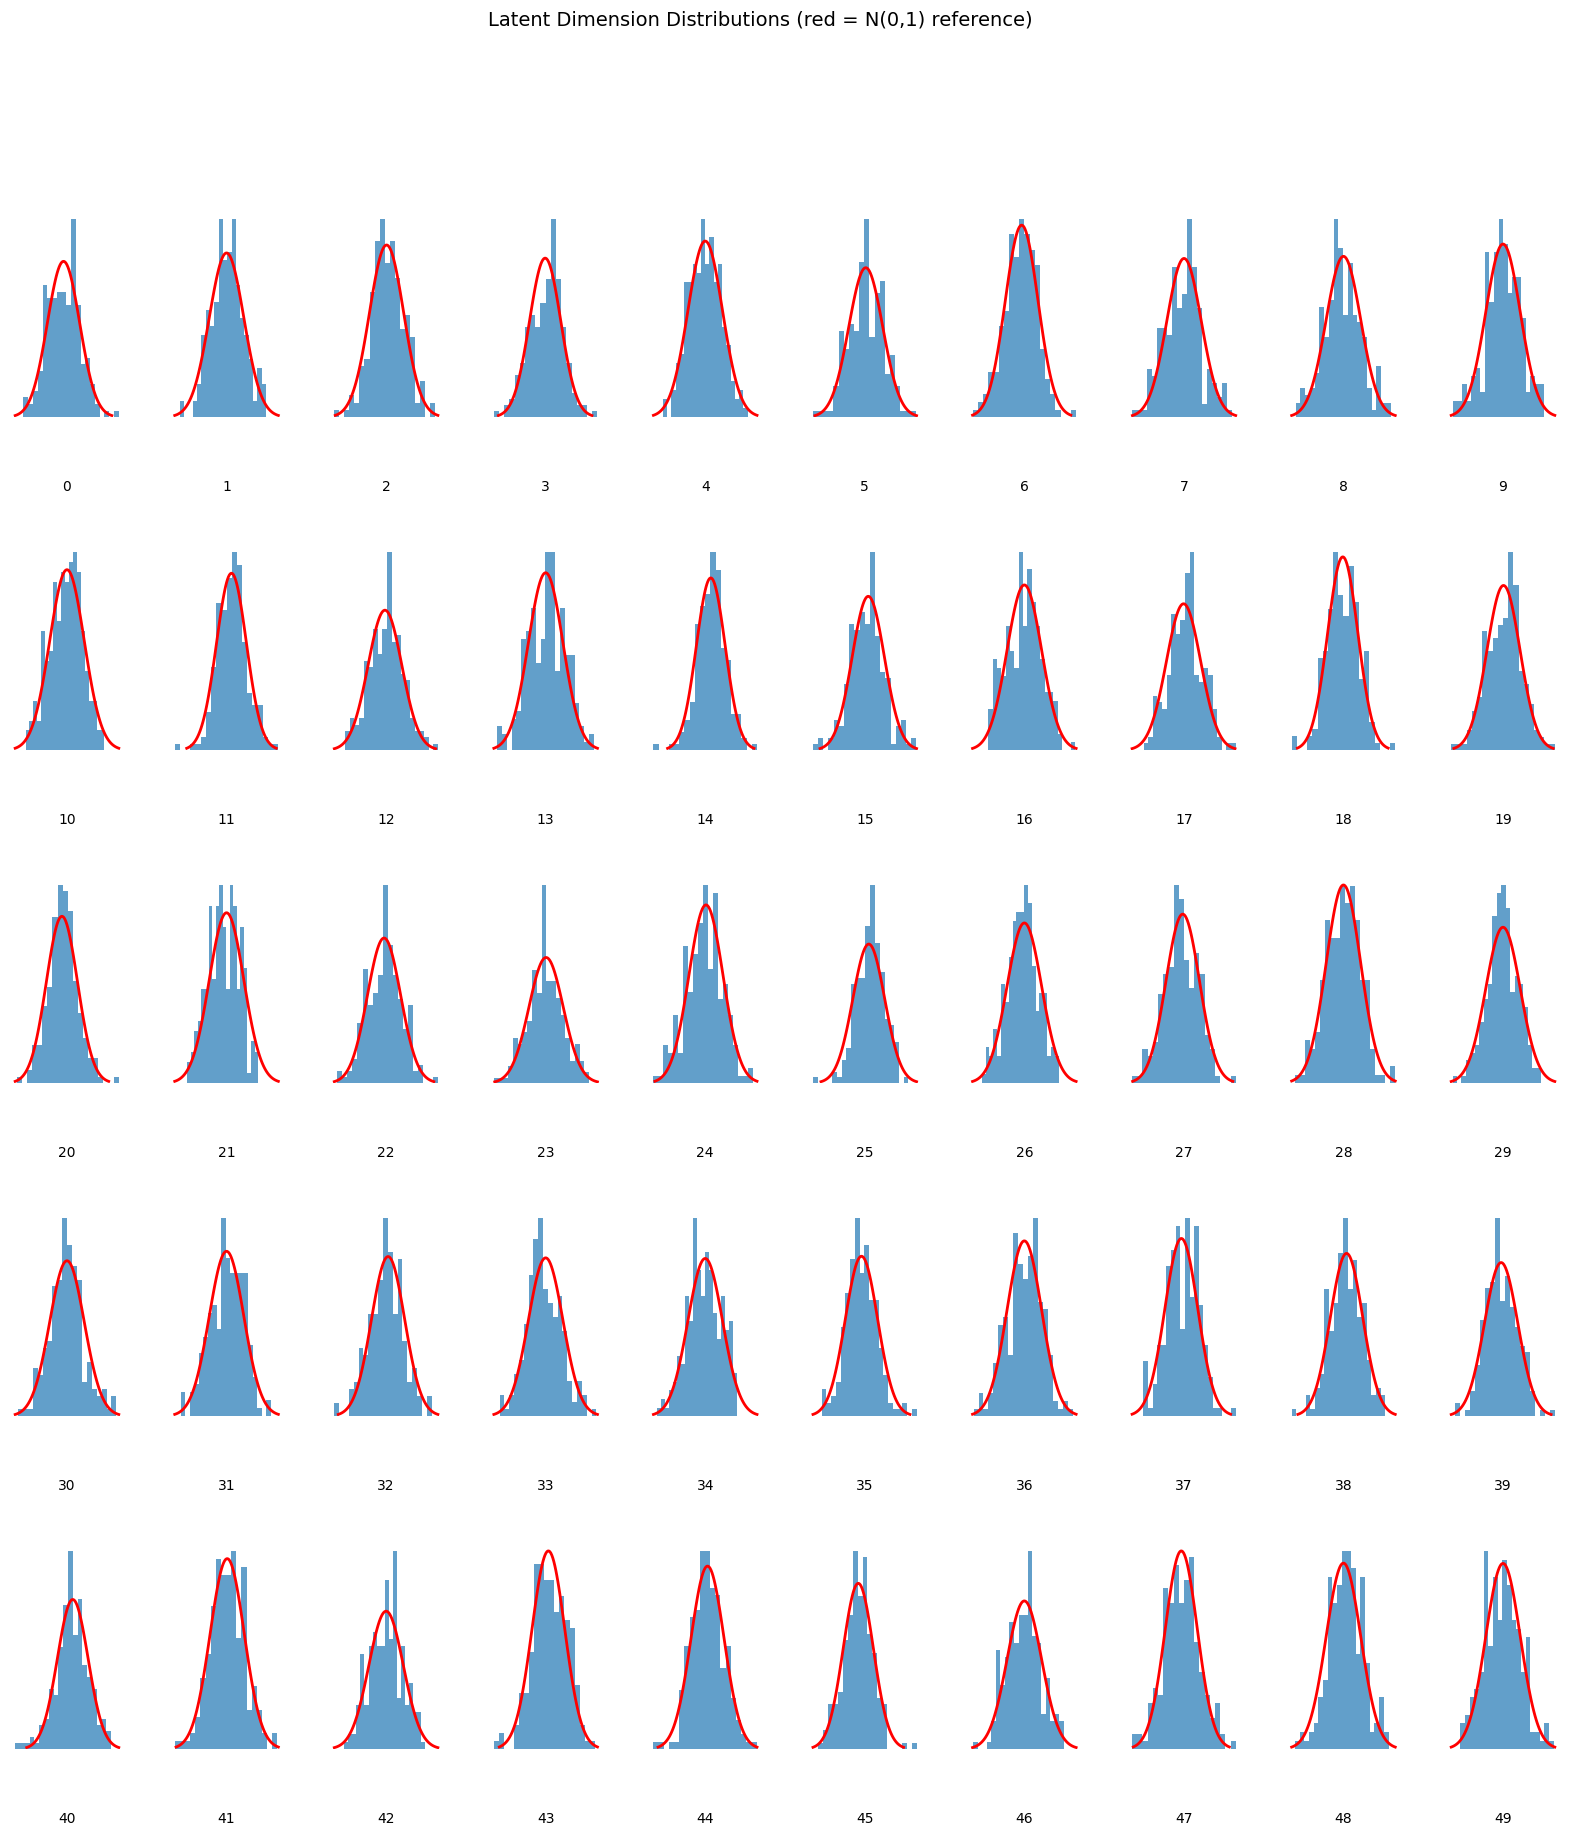

In [10]:
# Encode many images to analyze latent distribution
z_test = vae.encoder.predict(data_flow_generic, steps=20, verbose=1)

# Reference: standard normal distribution
x = np.linspace(-3, 3, 100)

# Plot histograms for first 50 latent dimensions
fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(50):
    ax = fig.add_subplot(5, 10, i + 1)
    ax.hist(z_test[:, i], density=True, bins=20, alpha=0.7)
    ax.plot(x, norm.pdf(x), 'r-', linewidth=2)  # Standard normal reference
    ax.axis('off')
    ax.text(0.5, -0.35, str(i), fontsize=10, ha='center', transform=ax.transAxes)

plt.suptitle('Latent Dimension Distributions (red = N(0,1) reference)', fontsize=14)
plt.show()

## Newly Generated Faces

Generate new faces by sampling from the latent space.
Since the latent space is trained to be approximately N(0,1), we sample random vectors.

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


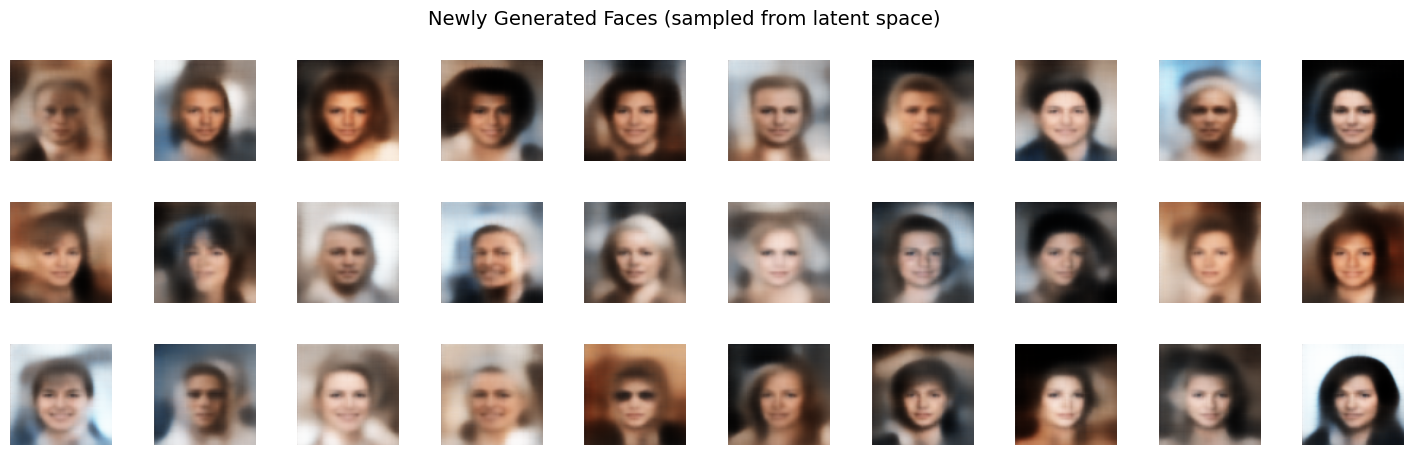

In [11]:
# Generate new faces from random latent vectors
N_GENERATED = 30

# Sample from standard normal distribution
z_new = np.random.normal(size=(N_GENERATED, vae.z_dim))

# Decode to image space
generated_faces = vae.decoder.predict(z_new)

# Display generated faces
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(N_GENERATED):
    ax = fig.add_subplot(3, 10, i + 1)
    ax.imshow(generated_faces[i])
    ax.axis('off')

plt.suptitle('Newly Generated Faces (sampled from latent space)', fontsize=14)
plt.show()

## Attribute Vector Arithmetic

Find directions in latent space that correspond to facial attributes.
By computing the mean latent vector for images with/without an attribute,
we can find a "feature vector" that represents that attribute.

In [12]:
def get_vector_from_label(label, batch_size):
    """
    Compute the attribute vector for a given facial attribute.
    
    The attribute vector is the difference between the mean latent vector
    of images WITH the attribute and images WITHOUT the attribute.
    
    Args:
        label (str): Attribute name from CelebA (e.g., 'Smiling', 'Eyeglasses')
        batch_size (int): Batch size for processing images
    
    Returns:
        np.ndarray: Normalized attribute vector in latent space
    """
    # Load images with attribute labels
    data_flow_label = imageLoader.build(att, batch_size, label=label)
    
    # Initialize accumulators for positive and negative samples
    current_sum_POS = np.zeros(shape=vae.z_dim, dtype='float32')
    current_sum_NEG = np.zeros(shape=vae.z_dim, dtype='float32')
    current_n_POS = 0
    current_n_NEG = 0
    current_mean_POS = np.zeros(shape=vae.z_dim, dtype='float32')
    current_mean_NEG = np.zeros(shape=vae.z_dim, dtype='float32')
    current_dist = 0
    
    print(f'Finding vector for: {label}')
    print('Images : POS move : NEG move : Distance : Δ Distance')
    
    # Iterate until convergence or max samples
    while current_n_POS < 10000:
        batch = next(data_flow_label)
        images = batch[0]
        attributes = batch[1]
        
        # Encode images to latent space
        z = vae.encoder.predict(images, verbose=0)
        
        # Split by attribute value
        z_POS = z[attributes == 1]
        z_NEG = z[attributes == -1]
        
        # Update positive mean
        if len(z_POS) > 0:
            current_sum_POS += np.sum(z_POS, axis=0)
            current_n_POS += len(z_POS)
            new_mean_POS = current_sum_POS / current_n_POS
            movement_POS = np.linalg.norm(new_mean_POS - current_mean_POS)
        else:
            movement_POS = 0
        
        # Update negative mean
        if len(z_NEG) > 0:
            current_sum_NEG += np.sum(z_NEG, axis=0)
            current_n_NEG += len(z_NEG)
            new_mean_NEG = current_sum_NEG / current_n_NEG
            movement_NEG = np.linalg.norm(new_mean_NEG - current_mean_NEG)
        else:
            movement_NEG = 0
        
        # Compute attribute vector (difference of means)
        current_vector = new_mean_POS - new_mean_NEG
        new_dist = np.linalg.norm(current_vector)
        dist_change = new_dist - current_dist
        
        print(f'{current_n_POS:6d} : {movement_POS:.4f} : {movement_NEG:.4f} : '
              f'{new_dist:.4f} : {dist_change:+.4f}')
        
        # Update state
        current_mean_POS = new_mean_POS.copy()
        current_mean_NEG = new_mean_NEG.copy()
        current_dist = new_dist
        
        # Convergence check: stop when means stabilize
        if movement_POS + movement_NEG < 0.08:
            current_vector = current_vector / current_dist  # Normalize
            print(f'✓ Found {label} vector (normalized)')
            break
    
    return current_vector

In [13]:
def add_vector_to_images(feature_vec, n_to_show=5):
    """
    Visualize the effect of adding/subtracting an attribute vector.
    
    Shows original face and variations with different amounts of the
    attribute vector added (from -4 to +4).
    
    Args:
        feature_vec (np.ndarray): Attribute vector to apply
        n_to_show (int): Number of faces to show
    """
    factors = [-4, -3, -2, -1, 0, 1, 2, 3, 4]
    
    # Load sample images
    example_batch = next(data_flow_generic)
    example_images = example_batch[0]
    
    # Encode to latent space
    z_points = vae.encoder.predict(example_images)
    
    # Create figure
    fig = plt.figure(figsize=(18, 10))
    counter = 1
    
    for i in range(n_to_show):
        # Show original image
        ax = fig.add_subplot(n_to_show, len(factors) + 1, counter)
        ax.axis('off')
        ax.imshow(example_images[i].squeeze())
        if i == 0:
            ax.set_title('Original', fontsize=8)
        counter += 1
        
        # Apply attribute vector with different strengths
        for factor in factors:
            # Vector arithmetic: z' = z + α * feature_vec
            modified_z = z_points[i] + feature_vec * factor
            modified_image = vae.decoder.predict(np.array([modified_z]))[0]
            
            ax = fig.add_subplot(n_to_show, len(factors) + 1, counter)
            ax.axis('off')
            ax.imshow(modified_image.squeeze())
            if i == 0:
                ax.set_title(f'{factor:+d}', fontsize=8)
            counter += 1
    
    plt.tight_layout()
    plt.show()

### Compute Attribute Vectors

In [14]:
# Batch size for attribute vector computation
ATTR_BATCH_SIZE = 500

# Compute vectors for various attributes
attractive_vec = get_vector_from_label('Attractive', ATTR_BATCH_SIZE)
mouth_open_vec = get_vector_from_label('Mouth_Slightly_Open', ATTR_BATCH_SIZE)
smiling_vec = get_vector_from_label('Smiling', ATTR_BATCH_SIZE)
lipstick_vec = get_vector_from_label('Wearing_Lipstick', ATTR_BATCH_SIZE)
cheekbones_vec = get_vector_from_label('High_Cheekbones', ATTR_BATCH_SIZE)
male_vec = get_vector_from_label('Male', ATTR_BATCH_SIZE)

Found 202599 validated image filenames.
Finding vector for: Attractive
Images : POS move : NEG move : Distance : Δ Distance
   254 : 1.0951 : 1.0647 : 1.6697 : +1.6697
   515 : 0.7155 : 0.6389 : 1.3746 : -0.2951
   792 : 0.4389 : 0.4261 : 1.2357 : -0.1389
  1029 : 0.2799 : 0.3152 : 1.1891 : -0.0466
  1278 : 0.2068 : 0.2248 : 1.1550 : -0.0341
  1530 : 0.1752 : 0.1880 : 1.0986 : -0.0564
  1778 : 0.1475 : 0.1478 : 1.0924 : -0.0062
  2031 : 0.1267 : 0.1403 : 1.0758 : -0.0165
  2280 : 0.1125 : 0.1208 : 1.0588 : -0.0170
  2513 : 0.0904 : 0.1055 : 1.0467 : -0.0122
  2774 : 0.0940 : 0.0996 : 1.0458 : -0.0009
  3014 : 0.0830 : 0.0848 : 1.0356 : -0.0101
  3272 : 0.0829 : 0.0771 : 1.0320 : -0.0036
  3524 : 0.0742 : 0.0763 : 1.0311 : -0.0010
  3762 : 0.0661 : 0.0716 : 1.0239 : -0.0071
  4002 : 0.0595 : 0.0709 : 1.0202 : -0.0037
  4266 : 0.0639 : 0.0627 : 1.0236 : +0.0034
  4535 : 0.0634 : 0.0591 : 1.0255 : +0.0019
  4799 : 0.0534 : 0.0570 : 1.0218 : -0.0038
  5060 : 0.0482 : 0.0535 : 1.0192 : -0.0

In [15]:
# Additional attribute vectors
eyeglasses_vec = get_vector_from_label('Eyeglasses', ATTR_BATCH_SIZE)

Found 202599 validated image filenames.
Finding vector for: Eyeglasses
Images : POS move : NEG move : Distance : Δ Distance
    29 : 3.2768 : 0.7675 : 3.3431 : +3.3431
    60 : 2.0614 : 0.5548 : 2.5994 : -0.7437
    86 : 1.0504 : 0.2919 : 2.3713 : -0.2281
   118 : 0.8899 : 0.2176 : 2.2869 : -0.0844
   151 : 0.6874 : 0.1666 : 2.1199 : -0.1669
   182 : 0.5219 : 0.1260 : 2.0141 : -0.1058
   219 : 0.4647 : 0.1183 : 1.9589 : -0.0553
   248 : 0.3690 : 0.0923 : 1.9799 : +0.0211
   279 : 0.3816 : 0.0837 : 1.9903 : +0.0104
   320 : 0.3323 : 0.0729 : 1.9628 : -0.0275
   354 : 0.2836 : 0.0665 : 1.9329 : -0.0299
   389 : 0.2501 : 0.0627 : 1.9127 : -0.0202
   423 : 0.2312 : 0.0579 : 1.8678 : -0.0448
   461 : 0.2389 : 0.0535 : 1.8188 : -0.0490
   495 : 0.1904 : 0.0497 : 1.8018 : -0.0170
   528 : 0.1726 : 0.0481 : 1.7998 : -0.0020
   556 : 0.1524 : 0.0456 : 1.7920 : -0.0078
   585 : 0.1504 : 0.0385 : 1.7940 : +0.0021
   629 : 0.1691 : 0.0396 : 1.7863 : -0.0078
   666 : 0.1362 : 0.0384 : 1.7809 : -0.0

In [16]:
blonde_vec = get_vector_from_label('Blond_Hair', ATTR_BATCH_SIZE)

Found 202599 validated image filenames.
Finding vector for: Blond_Hair
Images : POS move : NEG move : Distance : Δ Distance
    76 : 2.2311 : 0.8502 : 2.4451 : +2.4451
   148 : 1.2607 : 0.6246 : 2.0125 : -0.4327
   216 : 0.7158 : 0.3263 : 1.8150 : -0.1975
   286 : 0.5111 : 0.2119 : 1.7492 : -0.0658
   345 : 0.4013 : 0.1761 : 1.7374 : -0.0117
   420 : 0.3641 : 0.1428 : 1.6786 : -0.0588
   492 : 0.2802 : 0.1150 : 1.6546 : -0.0240
   567 : 0.2702 : 0.0995 : 1.6010 : -0.0536
   652 : 0.2407 : 0.0846 : 1.5672 : -0.0338
   721 : 0.1923 : 0.0857 : 1.5568 : -0.0104
   797 : 0.1803 : 0.0737 : 1.5375 : -0.0192
   868 : 0.1396 : 0.0665 : 1.5317 : -0.0058
   942 : 0.1316 : 0.0660 : 1.5339 : +0.0021
  1014 : 0.1427 : 0.0614 : 1.5373 : +0.0034
  1104 : 0.1329 : 0.0519 : 1.5283 : -0.0090
  1168 : 0.1107 : 0.0488 : 1.5232 : -0.0051
  1242 : 0.1125 : 0.0452 : 1.5198 : -0.0035
  1312 : 0.0955 : 0.0462 : 1.5069 : -0.0129
  1394 : 0.1050 : 0.0433 : 1.5098 : +0.0029
  1465 : 0.0906 : 0.0410 : 1.4986 : -0.0

### Apply Attribute Vectors

Eyeglasses Vector
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99m

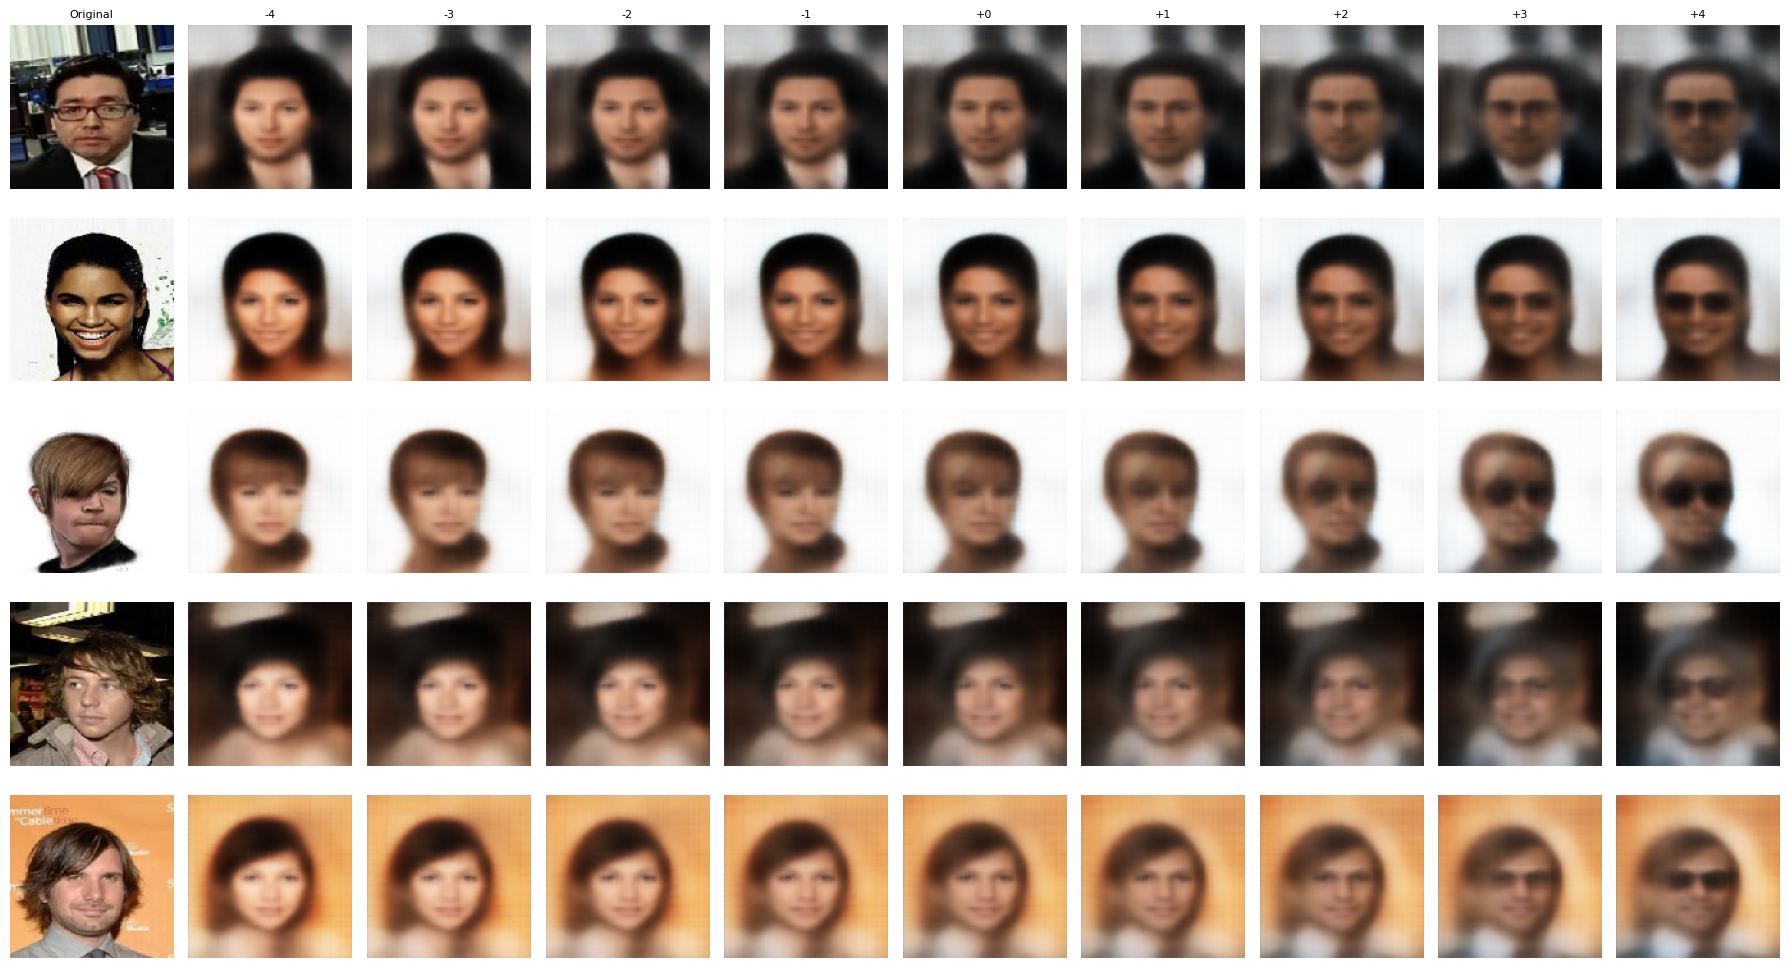

In [17]:
# Visualize attribute vector effects
# Uncomment the vectors you want to visualize

# print('Attractive Vector')
# add_vector_to_images(attractive_vec)

# print('Mouth Open Vector')
# add_vector_to_images(mouth_open_vec)

# print('Smiling Vector')
# add_vector_to_images(smiling_vec)

# print('Lipstick Vector')
# add_vector_to_images(lipstick_vec)

# print('High Cheekbones Vector')
# add_vector_to_images(cheekbones_vec)

# print('Male Vector')
# add_vector_to_images(male_vec)

print('Eyeglasses Vector')
add_vector_to_images(eyeglasses_vec)

# print('Blonde Hair Vector')
# add_vector_to_images(blonde_vec)

## Face Morphing

Interpolate between two faces in latent space.
This creates a smooth transition from one face to another,
demonstrating that the latent space is continuous and meaningful.

In [18]:
def morph_faces(start_image_file, end_image_file):
    """
    Create a morph sequence between two faces.
    
    Interpolates between two images in latent space and decodes
    intermediate points to create a smooth transition.
    
    Args:
        start_image_file (str): Filename of starting image
        end_image_file (str): Filename of ending image
    """
    factors = np.arange(0, 1, 0.1)
    
    # Load the two specific images
    att_specific = att[att['image_id'].isin([start_image_file, end_image_file])]
    att_specific = att_specific.reset_index()
    data_flow_label = imageLoader.build(att_specific, 2)
    
    example_batch = next(data_flow_label)
    example_images = example_batch[0]
    
    # Encode both images
    z_points = vae.encoder.predict(example_images)
    
    # Create morph sequence
    fig = plt.figure(figsize=(18, 8))
    counter = 1
    
    # Show start image
    ax = fig.add_subplot(1, len(factors) + 2, counter)
    ax.axis('off')
    ax.imshow(example_images[0].squeeze())
    ax.set_title('Start', fontsize=10)
    counter += 1
    
    # Interpolate between start and end
    for factor in factors:
        # Linear interpolation: z = (1-α) * z_start + α * z_end
        interpolated_z = z_points[0] * (1 - factor) + z_points[1] * factor
        interpolated_image = vae.decoder.predict(np.array([interpolated_z]))[0]
        
        ax = fig.add_subplot(1, len(factors) + 2, counter)
        ax.axis('off')
        ax.imshow(interpolated_image.squeeze())
        counter += 1
    
    # Show end image
    ax = fig.add_subplot(1, len(factors) + 2, counter)
    ax.axis('off')
    ax.imshow(example_images[1].squeeze())
    ax.set_title('End', fontsize=10)
    
    plt.suptitle('Face Morphing via Latent Space Interpolation', fontsize=12)
    plt.tight_layout()
    plt.show()

Found 2 non-validated image filenames.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


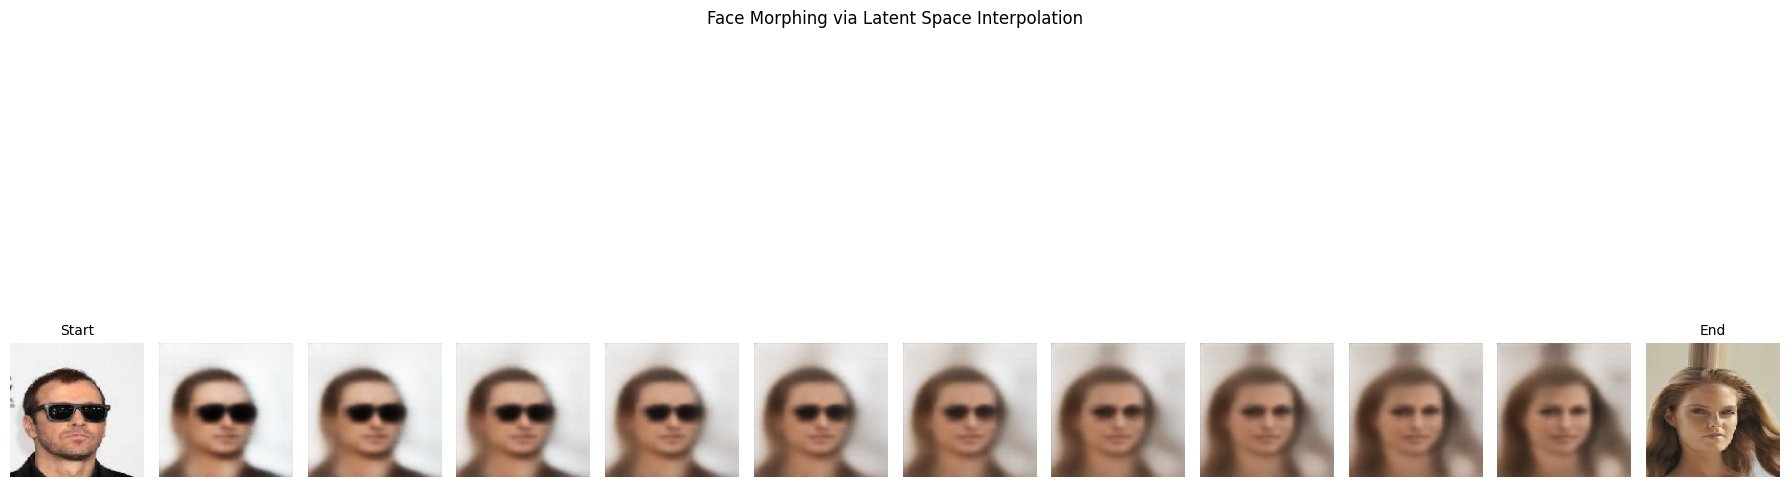

In [19]:
# Example morphs between different faces
morph_faces('000238.jpg', '000193.jpg')  # Person to glasses

Found 2 non-validated image filenames.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


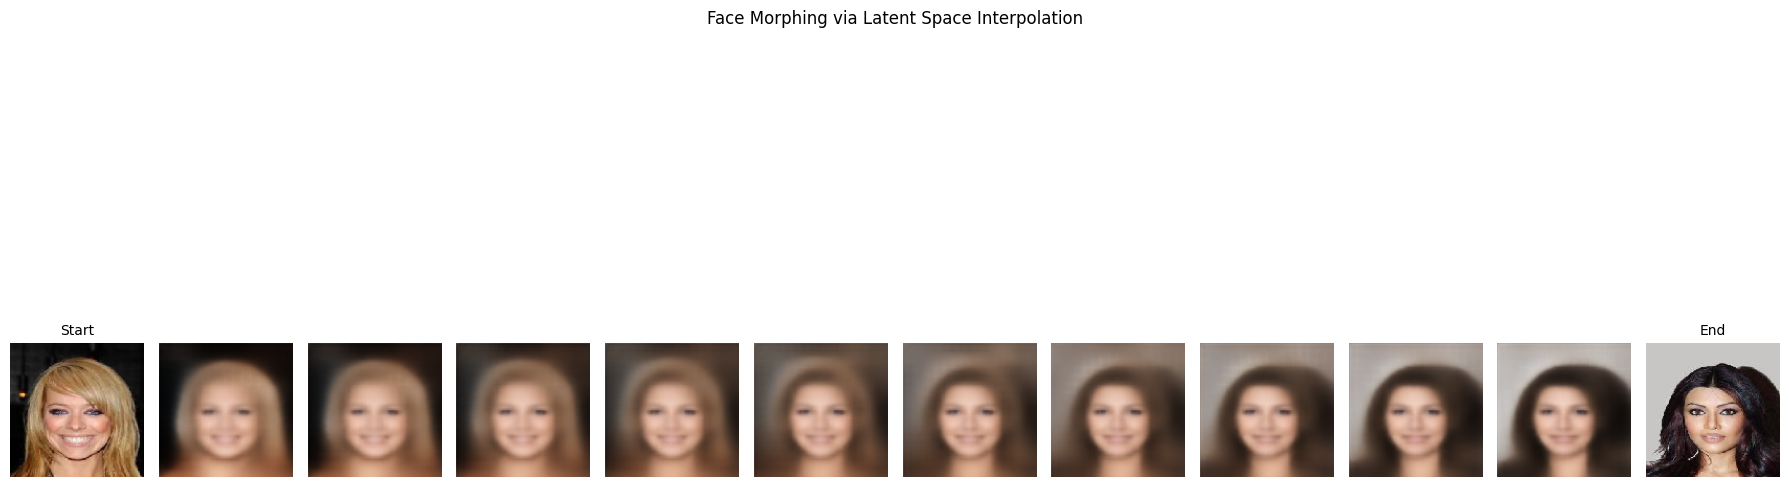

In [20]:
morph_faces('000112.jpg', '000258.jpg')

Found 2 non-validated image filenames.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


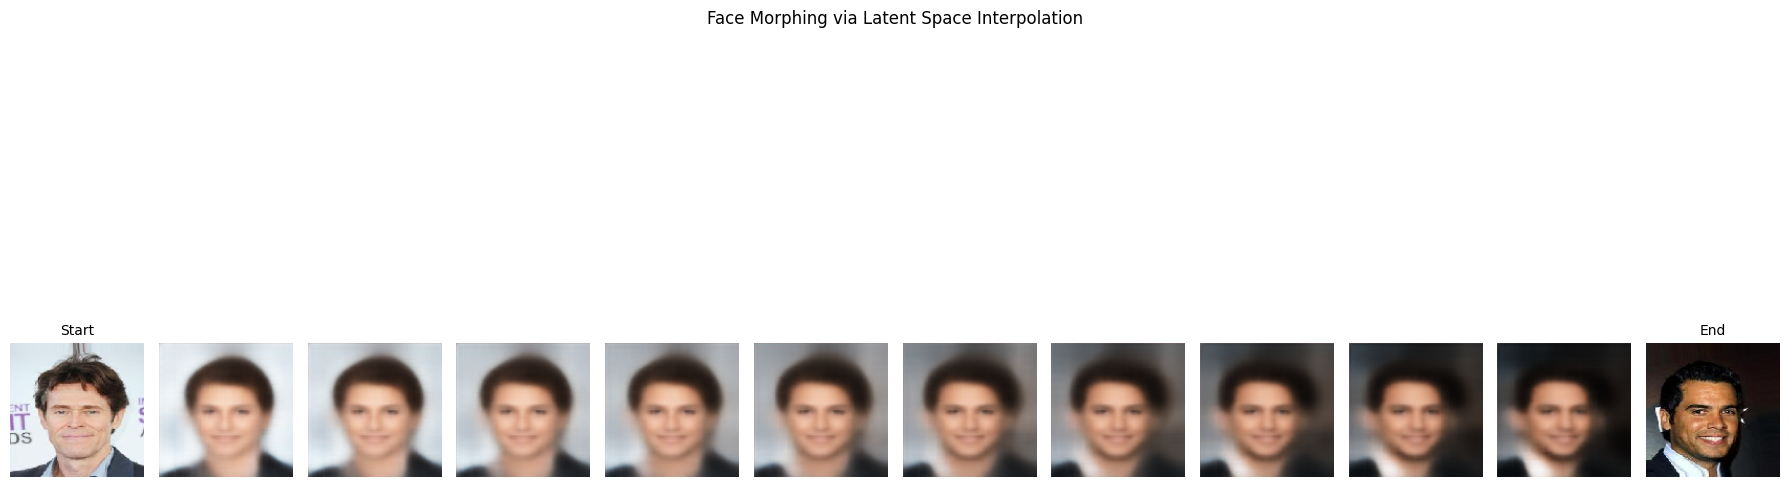

In [21]:
morph_faces('000230.jpg', '000712.jpg')

## Cleanup: Restart Kernel to Release GPU Memory

In [22]:
# ═══════════════════════════════════════════════════════════════════════════════
# CLEANUP: Restart kernel to fully release GPU memory
# ═══════════════════════════════════════════════════════════════════════════════
# TensorFlow/CUDA does not release GPU memory within a running Python process.
# Restarting the kernel is the only guaranteed way to free all GPU resources.
# Uncomment and run this cell only after all work is complete and saved.

# import IPython
# print("Restarting kernel to release GPU memory...")
# IPython.Application.instance().kernel.do_shutdown(restart=True)